In [1]:
import os, torch

# IMPORTANT: Fix for PyTorch/IPython compatibility issue
# This must run BEFORE importing torch to avoid decorator conflicts
# This fixes the "disable() got an unexpected keyword argument 'wrapping'" error

# Method 1: Try to disable dynamo via environment variable (needs to be set before import)
os.environ.setdefault('TORCH_COMPILE_DISABLE', '1')
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Method 2: Patch torch._dynamo.disable decorator after import
try:
    import torch._dynamo
    # Patch the disable function to ignore the 'wrapping' parameter
    if hasattr(torch._dynamo, 'disable'):
        def patched_disable(fn=None, *args, **kwargs):
            # Remove problematic 'wrapping' parameter if present
            if 'wrapping' in kwargs:
                kwargs.pop('wrapping')
            if fn is None:
                # Decorator usage: @disable
                return lambda f: f
            # Function usage: disable(fn) or disable(fn, **kwargs)
            # Simply return the function unwrapped to avoid recursion
            # The original disable was causing issues, so we bypass it entirely
            return fn
        torch._dynamo.disable = patched_disable
except Exception as e:
    print(f"Warning: Could not patch torch._dynamo: {e}")
    pass  # If patching fails, continue anyway


from torchtext import data
import numpy as np

import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
from utils import *

In [2]:
SEED = 42
train_data, validation_data, test_data, LABEL, TEXT, pretrained_embed = data_prep(SEED)

[*] Prepping Data...
[+] Test set formed!
[+] Train and Validation sets formed!
[+] Data prepped successfully!
[*] Retrieving pretrained word embeddings...
[*] Loading fasttext model...
[+] Model loaded!
[*] Forming embedding matrix...
[+] Embedding matrix formed!
[+] Embeddings retrieved successfully!

Label distribution in training set:
- ABBR: 69 samples (1.58%)
- DESC: 930 samples (21.32%)
- ENTY: 1000 samples (22.93%)
- HUM: 978 samples (22.42%)
- LOC: 668 samples (15.31%)
- NUM: 717 samples (16.44%)
Total samples: 4362, Sum of percentages: 100.00%


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
# Build vocabulary for labels
LABEL.build_vocab(train_data)
num_classes = len(LABEL.vocab)
print(f"\nNumber of classes: {num_classes}")
print(f"Classes: {LABEL.vocab.itos}")

# Get pretrained embeddings from Part 1 (frozen embeddings)
pretrained_embeddings = pretrained_embed.weight.data

# Get embedding dimension and vocab size from the fasttext embedding layer
embedding_dim = pretrained_embed.weight.shape[1]
embedding_vocab_size = pretrained_embed.weight.shape[0]  # Vocab size from saved embedding


Number of classes: 6
Classes: ['ENTY', 'HUM', 'DESC', 'NUM', 'LOC', 'ABBR']


In [5]:
# ============================================================================
# Part 3.2: Convolutional Neural Network (CNN) Model
# ============================================================================
# Replace simple RNN with CNN to produce sentence representations and perform topic classification

print("\n" + "="*80)
print("PART 3.2: CONVOLUTIONAL NEURAL NETWORK (CNN) MODEL")
print("="*80)

class CNNClassifier(nn.Module):
    """
    CNN for text classification using multiple filter sizes (n-gram features)
    Uses convolutional layers to extract local features and max pooling to create sentence representation
    """
    def __init__(self, vocab_size, embedding_dim, output_dim, 
                 num_filters=100, filter_sizes=[3, 4, 5], dropout=0.5, 
                 padding_idx=0, pretrained_embeddings=None):
        super(CNNClassifier, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.num_filters = num_filters
        self.filter_sizes = filter_sizes
        
        # Embedding layer initialized with pretrained embeddings
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(pretrained_embeddings)
            # Make embeddings learnable (updated during training)
            self.embedding.weight.requires_grad = True
        
        # Convolutional layers with different filter sizes
        self.convs = nn.ModuleList([
            nn.Conv1d(
                in_channels=embedding_dim,
                out_channels=num_filters,
                kernel_size=filter_size,
                padding=(filter_size - 1) // 2  # Proper "same" padding
            )
            for filter_size in filter_sizes
        ])
        
        # Dropout layers for regularization
        self.conv_dropout = nn.Dropout(dropout)
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected output layer
        # Input size is num_filters * len(filter_sizes) (concatenated features from all filters)
        self.fc = nn.Linear(num_filters * len(filter_sizes), output_dim)
        
    def forward(self, text, text_lengths):        
        # Embed the input
        embedded = self.embedding(text)  # [batch_size, seq_len, embedding_dim]

        embedded = embedded.permute(0, 2, 1)  # [batch_size, embedding_dim, seq_len]
        
        # Apply each convolutional filter and max pooling
        conv_outputs = []
        for conv in self.convs:
            conv_out = conv(embedded)
            conv_out = torch.relu(conv_out)
            conv_out = self.conv_dropout(conv_out)
            conv_outputs.append(conv_out)
        
        # Ensure all conv outputs have the same sequence length (consistent with hybrid model)
        min_seq_len = min(conv_out.size(2) for conv_out in conv_outputs)
        conv_outputs = [conv_out[:, :, :min_seq_len] for conv_out in conv_outputs]
        
        # Apply max pooling over time dimension (seq_len)
        # This extracts the most important feature for each filter
        pooled_outputs = []
        for conv_out in conv_outputs:
            pooled = torch.max(conv_out, dim=2)[0]
            pooled_outputs.append(pooled)
        
        # Concatenate features from all filter sizes
        # This combines information from different n-gram patterns
        concatenated = torch.cat(pooled_outputs, dim=1)
        
        # Apply dropout before FC layer
        concatenated = self.dropout(concatenated)
        
        # Pass through fully connected layer
        output = self.fc(concatenated)  # [batch_size, output_dim]
        
        return output

print(">>> CNNClassifier model class created")
print("    - Uses multiple convolutional filters with different sizes (3, 4, 5)")
print("    - Captures n-gram features at different scales")
print("    - Max pooling to create sentence representation")
print("    - Concatenates features from all filter sizes")


PART 3.2: CONVOLUTIONAL NEURAL NETWORK (CNN) MODEL
>>> CNNClassifier model class created
    - Uses multiple convolutional filters with different sizes (3, 4, 5)
    - Captures n-gram features at different scales
    - Max pooling to create sentence representation
    - Concatenates features from all filter sizes


In [6]:
# ============================================================================
# Train CNN Model
# ============================================================================

print("\n" + "="*80)
print("TRAINING CNN MODEL")
print("="*80)

# Set seed for reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Hyperparameters for CNN
CNN_HYPERPARAM = hyperparam_prep()

# Create data iterators
train_iter_cnn = data.BucketIterator(
    train_data,
    batch_size=CNN_HYPERPARAM['BATCH_SIZE'],
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=True,
    device=device
)

val_iter_cnn = data.BucketIterator(
    validation_data,
    batch_size=CNN_HYPERPARAM['BATCH_SIZE'],
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=False,
    device=device
)

test_iter_cnn = data.BucketIterator(
    test_data,
    batch_size=CNN_HYPERPARAM['BATCH_SIZE'],
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=False,
    device=device
)

# Create CNN model
cnn_model = CNNClassifier(
    vocab_size=embedding_vocab_size,
    embedding_dim=embedding_dim,
    output_dim=num_classes,
    num_filters=CNN_HYPERPARAM['NUM_FILTERS'],
    filter_sizes=CNN_HYPERPARAM['FILTER_SIZES'],
    dropout=CNN_HYPERPARAM['DROPOUT'],
    padding_idx=TEXT.vocab.stoi[TEXT.pad_token],
    pretrained_embeddings=pretrained_embeddings
).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Select optimizer with best learning rate
if CNN_HYPERPARAM['OPTIMIZER'] == 'Adam':
    cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=CNN_HYPERPARAM['LEARNING_RATE'],
                                    weight_decay=CNN_HYPERPARAM['L2_LAMBDA'])
elif CNN_HYPERPARAM['OPTIMIZER'] == 'SGD':
    cnn_optimizer = optim.SGD(cnn_model.parameters(), lr=CNN_HYPERPARAM['LEARNING_RATE'], momentum=0.9,
                                    weight_decay=CNN_HYPERPARAM['L2_LAMBDA'])
elif CNN_HYPERPARAM['OPTIMIZER'] == 'RMSprop':
    cnn_optimizer = optim.RMSprop(cnn_model.parameters(), lr=CNN_HYPERPARAM['LEARNING_RATE'],
                                    weight_decay=CNN_HYPERPARAM['L2_LAMBDA'])
elif CNN_HYPERPARAM['OPTIMIZER'] == 'Adagrad':
    cnn_optimizer = optim.Adagrad(cnn_model.parameters(), lr=CNN_HYPERPARAM['LEARNING_RATE'],
                                    weight_decay=CNN_HYPERPARAM['L2_LAMBDA'])

print(f"\n>>> CNN Model Configuration:")
print(f"    Number of Filters: {CNN_HYPERPARAM['NUM_FILTERS']} per filter size")
print(f"    Filter Sizes: {CNN_HYPERPARAM['FILTER_SIZES']} (captures {', '.join([f'{s}-grams' for s in CNN_HYPERPARAM['FILTER_SIZES']])})")
print(f"    Total Feature Size: {CNN_HYPERPARAM['NUM_FILTERS'] * len(CNN_HYPERPARAM['FILTER_SIZES'])}")
print(f"    Dropout: {CNN_HYPERPARAM['DROPOUT']}")
print(f"    Learning Rate: {CNN_HYPERPARAM['LEARNING_RATE']}")
print(f"    Batch Size: {CNN_HYPERPARAM['BATCH_SIZE']}")
print(f"    Max Epochs: {CNN_HYPERPARAM['N_EPOCHS']}, Patience: {CNN_HYPERPARAM['PATIENCE']}")

# Train CNN model
cnn_model, cnn_history = train_model_with_history(
    cnn_model, train_iter_cnn, val_iter_cnn, cnn_optimizer, criterion,
    CNN_HYPERPARAM['N_EPOCHS'], device, num_classes, CNN_HYPERPARAM['L1_LAMBDA'], patience=CNN_HYPERPARAM['PATIENCE'], model_name="CNN"
)

# Save best model
torch.save(cnn_model.state_dict(), 'weights/cnn_best.pt')
print(f"\n>>> CNN model saved to 'weights/cnn_best.pt'")


TRAINING CNN MODEL

>>> CNN Model Configuration:
    Number of Filters: 100 per filter size
    Filter Sizes: [3, 4, 5] (captures 3-grams, 4-grams, 5-grams)
    Total Feature Size: 300
    Dropout: 0.7
    Learning Rate: 0.0001
    Batch Size: 32
    Max Epochs: 100, Patience: 10

>>> Training CNN
    Parameters: 2,796,006
    Max epochs: 100, Patience: 10
Epoch: 01/100 | Time: 0m 0s
	Train Loss: 1.6920 | Train Acc: 24.46%
	Val Loss: 1.6853 | Val Acc: 29.27% | Val F1: 0.2059 | Val AUC: 0.7283
Epoch: 02/100 | Time: 0m 0s
	Train Loss: 1.5942 | Train Acc: 34.07%
	Val Loss: 1.6344 | Val Acc: 42.29% | Val F1: 0.3634 | Val AUC: 0.7989
Epoch: 03/100 | Time: 0m 0s
	Train Loss: 1.5013 | Train Acc: 43.28%
	Val Loss: 1.5593 | Val Acc: 49.36% | Val F1: 0.4620 | Val AUC: 0.8369
Epoch: 04/100 | Time: 0m 0s
	Train Loss: 1.3460 | Train Acc: 51.93%
	Val Loss: 1.4382 | Val Acc: 54.59% | Val F1: 0.5108 | Val AUC: 0.8718
Epoch: 05/100 | Time: 0m 0s
	Train Loss: 1.1801 | Train Acc: 58.53%
	Val Loss: 1.314

In [7]:
# ============================================================================
# Evaluate CNN Model on Test Set
# ============================================================================

print("\n" + "="*80)
print("TEST SET EVALUATION - CNN")
print("="*80)

# Evaluate CNN
print("\n>>> Evaluating CNN on test set...")
cnn_test_loss, cnn_test_acc, cnn_test_f1, cnn_test_auc = evaluate_model(
    cnn_model, test_iter_cnn, criterion, device, "CNN", num_classes
)

print(f"\n>>> CNN Test Set Results:")
print(f"    Test Loss: {cnn_test_loss:.4f}")
print(f"    Test Accuracy: {cnn_test_acc*100:.2f}%")
print(f"    Test F1 Score: {cnn_test_f1:.4f}")
print(f"    Test AUC-ROC: {cnn_test_auc:.4f}")


TEST SET EVALUATION - CNN

>>> Evaluating CNN on test set...

>>> CNN Test Set Results:
    Test Loss: 0.4663
    Test Accuracy: 89.60%
    Test F1 Score: 0.8957
    Test AUC-ROC: 0.9815


In [8]:
# ============================================================================
# Part 3.2 Summary - CNN Model
# ============================================================================

print("\n" + "="*80)
print("PART 3.2 SUMMARY - CNN MODEL")
print("="*80)
print(f"{'Model':<15} {'Val Acc':<12} {'Val F1':<12} {'Val AUC':<12} {'Test Acc':<12} {'Test F1':<12} {'Test AUC':<12}")
print("-" * 90)
print(f"{'CNN':<15} {cnn_history['best_val_acc']*100:<12.2f}% {cnn_history['best_val_f1']:<12.4f} {cnn_history['best_val_auc']:<12.4f} {cnn_test_acc*100:<12.2f}% {cnn_test_f1:<12.4f} {cnn_test_auc:<12.4f}")
print("="*90)

print("\n>>> Part 3.2 Complete!")
print("    - CNN model implemented with multiple filter sizes (3, 4, 5)")
print("    - Captures n-gram features at different scales")
print("    - Max pooling to create sentence representation")
print("    - All metrics (Accuracy, F1, AUC-ROC) reported for validation and test sets")


PART 3.2 SUMMARY - CNN MODEL
Model           Val Acc      Val F1       Val AUC      Test Acc     Test F1      Test AUC    
------------------------------------------------------------------------------------------
CNN             88.17       % 0.8816       0.9790       89.60       % 0.8957       0.9815      

>>> Part 3.2 Complete!
    - CNN model implemented with multiple filter sizes (3, 4, 5)
    - Captures n-gram features at different scales
    - Max pooling to create sentence representation
    - All metrics (Accuracy, F1, AUC-ROC) reported for validation and test sets



PLOTTING TRAINING CURVES - CNN
    Saved training curves to 'part3_2_cnn_training_curves.png'


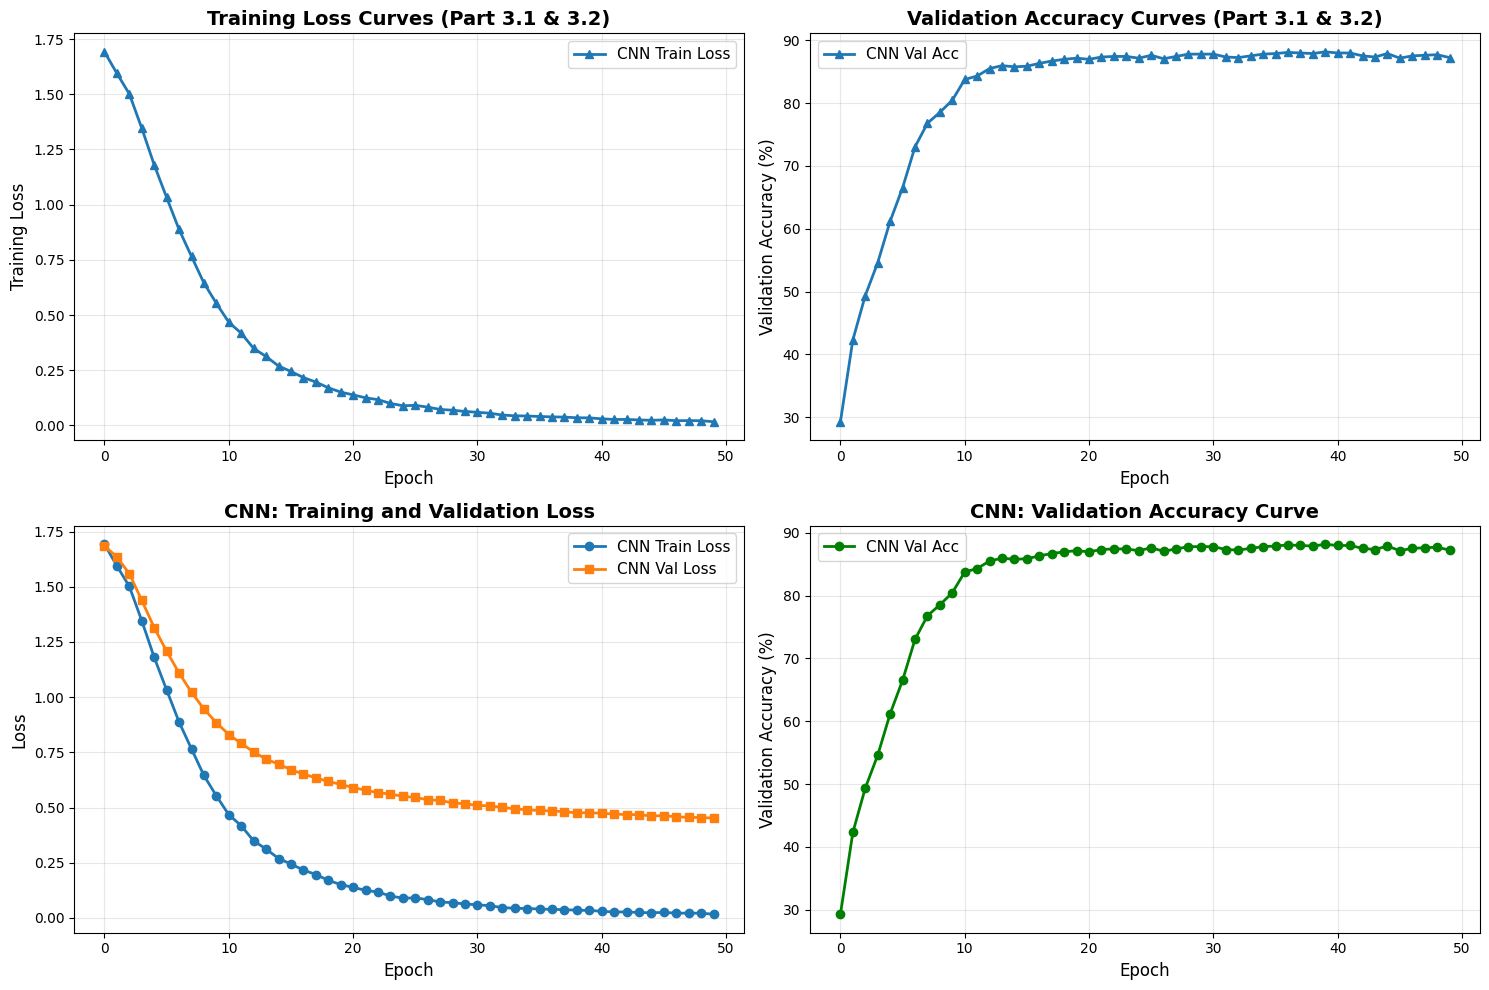

    Saved Part 3.2 curves to 'part3_2_training_curves.png'


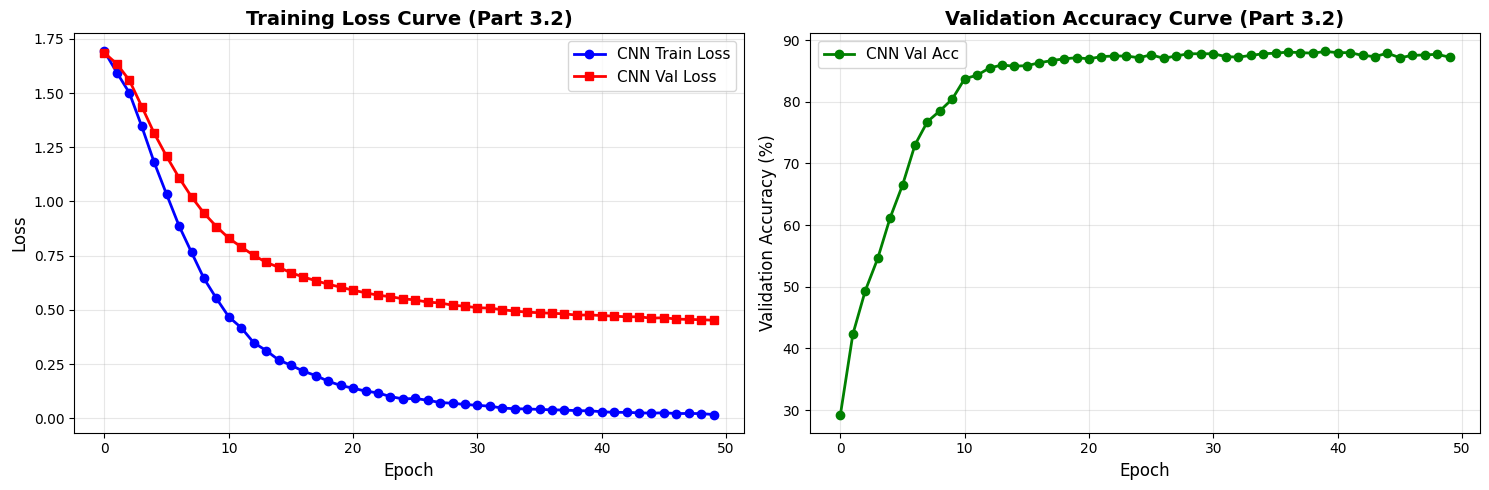


>>> Training curves plotted and saved for CNN model


In [9]:
# ============================================================================
# Plot Training Curves for CNN
# ============================================================================

print("\n" + "="*80)
print("PLOTTING TRAINING CURVES - CNN")
print("="*80)

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# NOTE: BILSTM and BIGRU history not available to plot
# Plot 1: Training Loss Curves (Comparison: biLSTM, biGRU, CNN)
# axes[0, 0].plot(bilstm_history['train_losses'], label='biLSTM Train Loss', marker='o', linewidth=2)
# axes[0, 0].plot(bigru_history['train_losses'], label='biGRU Train Loss', marker='s', linewidth=2)
axes[0, 0].plot(cnn_history['train_losses'], label='CNN Train Loss', marker='^', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Training Loss', fontsize=12)
axes[0, 0].set_title('Training Loss Curves (Part 3.1 & 3.2)', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Validation Accuracy Curves (Comparison: biLSTM, biGRU, CNN)
# axes[0, 1].plot([acc*100 for acc in bilstm_history['val_accs']], label='biLSTM Val Acc', marker='o', linewidth=2)
# axes[0, 1].plot([acc*100 for acc in bigru_history['val_accs']], label='biGRU Val Acc', marker='s', linewidth=2)
axes[0, 1].plot([acc*100 for acc in cnn_history['val_accs']], label='CNN Val Acc', marker='^', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Validation Accuracy (%)', fontsize=12)
axes[0, 1].set_title('Validation Accuracy Curves (Part 3.1 & 3.2)', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: CNN Training and Validation Loss
axes[1, 0].plot(cnn_history['train_losses'], label='CNN Train Loss', marker='o', linewidth=2)
axes[1, 0].plot(cnn_history['val_losses'], label='CNN Val Loss', marker='s', linewidth=2)
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Loss', fontsize=12)
axes[1, 0].set_title('CNN: Training and Validation Loss', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: CNN Training and Validation Accuracy
axes[1, 1].plot([acc*100 for acc in cnn_history['val_accs']], label='CNN Val Acc', marker='o', linewidth=2, color='green')
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Validation Accuracy (%)', fontsize=12)
axes[1, 1].set_title('CNN: Validation Accuracy Curve', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('part3_2_cnn_training_curves.png', dpi=300, bbox_inches='tight')
print(f"    Saved training curves to 'part3_2_cnn_training_curves.png'")
plt.show()  # Display the plot in notebook

# Also create separate plots for Part 3.2 requirement (training loss and validation accuracy)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Training Loss Curve
ax1.plot(cnn_history['train_losses'], label='CNN Train Loss', marker='o', linewidth=2, color='blue')
ax1.plot(cnn_history['val_losses'], label='CNN Val Loss', marker='s', linewidth=2, color='red')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training Loss Curve (Part 3.2)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Validation Accuracy Curve
ax2.plot([acc*100 for acc in cnn_history['val_accs']], label='CNN Val Acc', marker='o', linewidth=2, color='green')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Validation Accuracy (%)', fontsize=12)
ax2.set_title('Validation Accuracy Curve (Part 3.2)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('part3_2_training_curves.png', dpi=300, bbox_inches='tight')
print(f"    Saved Part 3.2 curves to 'part3_2_training_curves.png'")
plt.show()  # Display the plot in notebook

print("\n>>> Training curves plotted and saved for CNN model")